In [1]:
import os
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pymc_marketing import clv
os.chdir("../")
from src.data import (
    getDataset,
    ProcessData
)
from src.config import RawFeatures, RFM
from src.models import BetaGeoModel
from src.utils import get_customer_history_data, get_customer_whatif_data

In [2]:
import arviz as az
from arviz.labels import MapLabeller

In [3]:
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

In [4]:
dt_format_ = '%d/%m/%Y %H:%M'
_dt_format = '%Y-%m-%d %H:%M'
df_transaction = getDataset()
df_transaction[RawFeatures.TRANSACTION_DATE] = df_transaction[RawFeatures.TRANSACTION_DATE].apply(
                                                    lambda x: dt.datetime.strptime(x, dt_format_).strftime(_dt_format) if x==x else x)

In [5]:
df_transaction.head()


,Customer ID,InvoiceDate,Price,Quantity
0,13085.0,2009-12-01 07:45,6.95,12.0
1,13085.0,2009-12-01 07:45,6.75,12.0
2,13085.0,2009-12-01 07:45,6.75,12.0
3,13085.0,2009-12-01 07:45,2.10,48.0
4,13085.0,2009-12-01 07:45,1.25,24.0


In [6]:
# pd.to_datetime(
#    df_transaction[RawFeatures.TRANSACTION_DATE].dropna().apply(lambda x: dt.datetime.strptime(x, '%d/%m/%Y %H:%M')),
# ).dt.date

In [7]:
data_inst = ProcessData(df_transaction, 'D', '2011-06-30')
data_summary = data_inst.model_data()
data_summary.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,7.0,400.0,725.0,11066.637143
12745.0,1.0,88.0,574.0,266.930000
12747.0,25.0,730.0,732.0,355.835600
12748.0,202.0,735.0,735.0,279.101436
12749.0,6.0,518.0,521.0,1010.743333


In [8]:
data_summary.sort_values("T")

,frequency,recency,T,monetary_value
Customer ID,,,,
15060.0,1.0,1.0,9.0,16.610000
13521.0,2.0,9.0,10.0,402.885000
13596.0,1.0,7.0,12.0,285.440000
17232.0,1.0,12.0,14.0,213.480000
14785.0,1.0,5.0,15.0,37.920000
...,...,...,...,...
16763.0,1.0,540.0,738.0,611.850000
16167.0,3.0,324.0,738.0,300.110000
14110.0,31.0,735.0,738.0,409.770645


In [9]:
data_summary.shape

(3820, 4)

In [10]:
data_summary.describe().iloc[[1, 2, 3, 5, 7], :]

,frequency,recency,T,monetary_value
mean,6.490052,386.782461,526.574346,422.646958
std,10.721823,227.335755,201.691737,2771.151697
min,1.000000,1.000000,9.000000,3.900000
50%,3.000000,389.000000,592.000000,300.305000
max,202.000000,738.000000,738.000000,168469.600000


In [11]:
RFM()

RFM(max_recency=0.0, max_T=0.0)

# Modeling


In [12]:
bgm = BetaGeoModel(data_summary, 7)
bgm.fit()
bgm.fit_summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.113,0.012,0.090,0.135,0.000,0.000,2143.0,1947.0,1.0
b,1.274,0.197,0.900,1.618,0.004,0.003,2164.0,1948.0,1.0
alpha,95.860,2.987,90.437,101.647,0.065,0.046,2114.0,1613.0,1.0
r,1.434,0.039,1.353,1.501,0.001,0.001,2120.0,1435.0,1.0


# Plots

In [13]:
# az.plot_posterior(bgm.fit_result);

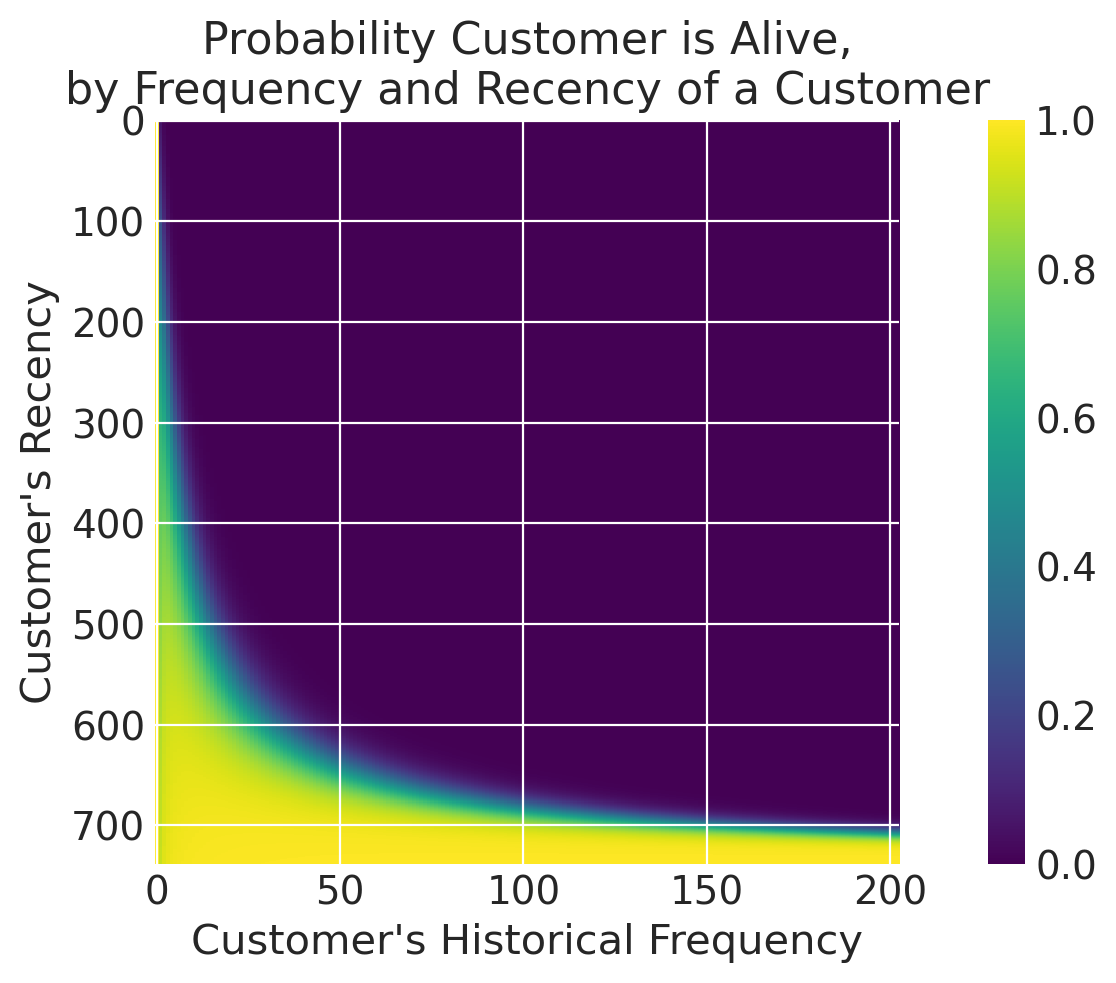

In [14]:
clv.plot_probability_alive_matrix(bgm);

In [15]:
customer_id = 16167.0
n_period = 7
T_future_transac = 2

In [16]:
get_customer_history_data(data_summary, customer_id, n_period)

,Customer ID,frequency,recency,T
0,16167,3,324.0,737
1,16167,3,324.0,738
2,16167,3,324.0,739
3,16167,3,324.0,740
4,16167,3,324.0,741
5,16167,3,324.0,742
6,16167,3,324.0,743


In [17]:
# BetaGeoModel.expected_num_purchases(customer_id, t, frequency, recency, T)

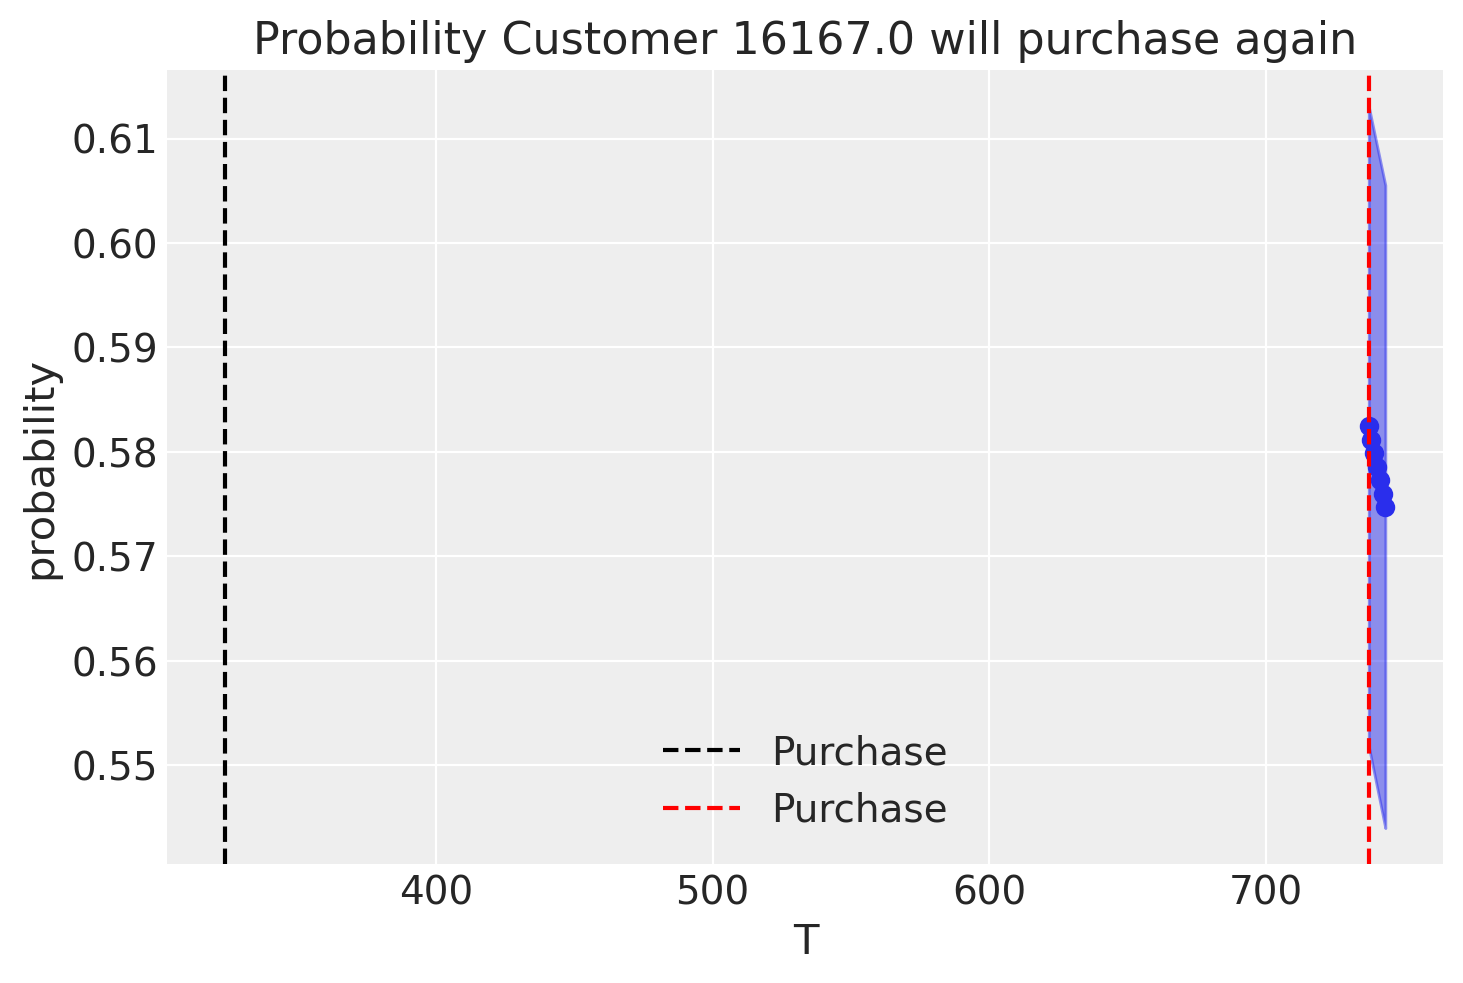

In [18]:
bgm.plot_probability_alive(
    customer_id,
    n_period)